In [52]:
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import time
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from wordcloud import WordCloud

In [53]:
def investigate_data_quality(df):
    print("\n--- Data Quality Investigation ---")

    # 1. Check for missing values
    missing_values = df.isnull().sum()
    print("\nMissing Values per Column:\n", missing_values)
    plt.figure(figsize=(10, 6))
    missing_values.sort_values(ascending=False).plot(kind='barh', color='skyblue')
    plt.title('Percentage of Missing Values per Column')
    plt.xlabel('Percentage of Missing Values')
    plt.ylabel('Columns')
    plt.show()

    # 2. Check for duplicate rows
    duplicate_count = df.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicate_count}")

    plt.figure(figsize=(6, 4))
    plt.bar(['Duplicate Rows', 'Unique Rows'], [duplicate_count, len(df) - duplicate_count], color=['orange', 'green'])
    plt.title('Duplicate Records in the Dataset')
    plt.ylabel('Number of Records')
    plt.show()


    # 3. Check for invalid salary ranges
    invalid_salaries = df[(df['salaire_min'] > df['salaire_max']) |
                          ((~df['salaire_min'].isnull()) & df['salaire_max'].isnull())]
    print(f"\nNumber of invalid salary ranges: {len(invalid_salaries)}")

    # 4. Check for invalid contract types or durations
    print("\nUnique Contract Types:", df['type_contrat'].unique())
    print("\nUnique Contract Durations:", df['temps_contrat'].unique())

    # 5. Validate publication dates
    df['date_publication'] = pd.to_datetime(df['date_publication'], errors='coerce')
    invalid_dates = df['date_publication'].isnull().sum()
    print(f"\nNumber of invalid publication dates: {invalid_dates}")

    # 6. Validate URL format
    def is_valid_url(url):
        try:
            result = urlparse(url)
            return all([result.scheme, result.netloc])
        except ValueError:
            return False
    invalid_urls = ~df['url'].apply(is_valid_url)
    print(f"\nNumber of invalid URLs: {invalid_urls.sum()}")


In [54]:
def fix_data_quality(df):
    # 1. Handle missing values
    df.fillna({"temps_contrat":"Not Specified"}, inplace=True)
    # Check if the min and max salaries are available and impute missing salary
    df['salaire'] = df.apply(
        lambda row: (row['salaire_min'] + row['salaire_max']) / 2 if pd.isnull(row['salaire']) else row['salaire'],
        axis=1
    )
    df.fillna({"salaire_min": 0}, inplace=True)
    df.fillna({"salaire_max": 0}, inplace=True)
    df.fillna({"salaire": 0}, inplace=True)
    print("\nMissing values handled.")
    return df


In [55]:
def analyze_job_offers(df):
    # Ensure the 'date_publication' is in datetime format
    df['date_publication'] = pd.to_datetime(df['date_publication'], errors='coerce')

    # Dictionary to store results
    results = {}

    # Function to record time taken for each query
    def log_time(query_name, start_time):
        elapsed_time = time.time() - start_time
        print(f"Time taken for {query_name}: {elapsed_time:.4f} seconds")

    # ------------------- 1. Salary Insights -------------------
    start_time = time.time()
    # Average salary by category
    results['avg_salary_by_category'] = df.groupby('catégorie')[['salaire_min', 'salaire_max']].mean()
    log_time('Average Salary by Category', start_time)

    start_time = time.time()
    # Average salary by region
    results['avg_salary_by_region'] = df.groupby('localisation')[['salaire_min', 'salaire_max']].mean()
    log_time('Average Salary by Region', start_time)

    start_time = time.time()
    # Salary outliers detection
    results['salary_outliers'] = df[(df['salaire_min'] > df['salaire_max'] * 2) | (df['salaire_min'] < 0) | (df['salaire_max'] < 0)]
    log_time('Salary Outliers Detection', start_time)

    # ------------------- 2. Contract Type Analysis -------------------
    start_time = time.time()
    # Contract type distribution
    results['contract_type_distribution'] = df['type_contrat'].value_counts()
    log_time('Contract Type Distribution', start_time)

    start_time = time.time()
    # Salary range by contract type
    results['contract_salary_stats'] = df.groupby('type_contrat')[['salaire_min', 'salaire_max']].mean()
    log_time('Salary Range by Contract Type', start_time)

    # ------------------- 3. Job Category and Location Insights -------------------
    start_time = time.time()
    # Most common job categories
    results['most_common_categories'] = df['catégorie'].value_counts().head(10)
    log_time('Most Common Job Categories', start_time)

    start_time = time.time()
    # Job offers by region and category
    results['jobs_by_region_category'] = df.groupby(['localisation', 'catégorie']).size().unstack(fill_value=0)
    log_time('Job Offers by Region and Category', start_time)

    start_time = time.time()
    # Job offers per region over time
    df['month'] = df['date_publication'].dt.month_name()
    results['job_offers_per_region_time'] = df.groupby(['month', 'localisation']).size().unstack(fill_value=0)
    log_time('Job Offers per Region Over Time', start_time)

    # ------------------- 4. Temporal Trends and Seasonality -------------------
    start_time = time.time()
    # Monthly seasonality in job offers
    results['job_offers_seasonality'] = df.groupby(df['date_publication'].dt.to_period('M')).size()
    log_time('Monthly Seasonality', start_time)

    start_time = time.time()
    # Hiring trends over years
    df['year'] = df['date_publication'].dt.year
    results['job_offers_per_year'] = df.groupby('year').size()
    log_time('Hiring Trends Over Years', start_time)

    start_time = time.time()
    # Word Cloud for Job Titles
    job_titles = ' '.join(df['intitulé'].dropna())
    wordcloud = WordCloud(width=800, height=400).generate(job_titles)
    results['wordcloud'] = wordcloud
    log_time('Job Title Word Cloud Generation', start_time)

    start_time = time.time()
    # Feature correlation between salary and region
    results['salary_region_correlation'] = df[['salaire_min', 'salaire_max', 'localisation']].groupby('localisation').mean()
    log_time('Salary by Region Correlation', start_time)

    # ------------------- 8. Job Offers Distribution by Industry -------------------
    start_time = time.time()
    results['industry_distribution'] = df['catégorie'].value_counts()
    log_time('Job Offers Distribution by Industry', start_time)

    return results

In [56]:
def plot_all_job_offer_results(results):
    # Set the style of the plots
    sns.set(style="whitegrid")

    # 1. Plot: Job Offers per Month (Seasonality)
    plt.figure(figsize=(10, 6))
    results['job_offers_seasonality'].plot(kind='line', marker='o', color='orange')
    plt.title('Number of Job Offers per Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Job Offers')
    plt.grid()
    plt.xticks(rotation=90)
    plt.show()

    # 2. Plot: Word Cloud for Job Titles
    plt.figure(figsize=(10, 6))
    plt.imshow(results['wordcloud'], interpolation='bilinear')
    plt.axis("off")
    plt.title('Job Title Word Cloud')
    plt.show()

    # 3. Plot: Average Salary by Category
    avg_salary_by_category = results['avg_salary_by_category']
    plt.figure(figsize=(12, 8))
    avg_salary_by_category[['salaire_min', 'salaire_max']].plot(kind='bar', color=['skyblue', 'orange'])
    plt.title('Average Salary by Category')
    plt.xlabel('Category')
    plt.ylabel('Average Salary')
    plt.xticks(rotation=90)
    plt.legend(title='Salary', loc='upper left')
    plt.show()

    # 4. Plot: Average Salary by Region
    avg_salary_by_region = results['avg_salary_by_region']
    plt.figure(figsize=(12, 8))
    avg_salary_by_region[['salaire_min', 'salaire_max']].plot(kind='bar', color=['skyblue', 'orange'])
    plt.title('Average Salary by Region')
    plt.xlabel('Region')
    plt.ylabel('Average Salary')
    plt.xticks(rotation=90)
    plt.legend(title='Salary', loc='upper left')
    plt.show()

    # 5. Plot: Contract Type Distribution
    plt.figure(figsize=(8, 6))
    results['contract_type_distribution'].plot(kind='bar', color='steelblue')
    plt.title('Contract Type Distribution')
    plt.xlabel('Contract Type')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

    # 6. Plot: Job Offers by Region and Category (Heatmap)
    jobs_by_region_category = results['jobs_by_region_category']
    plt.figure(figsize=(12, 8))
    sns.heatmap(jobs_by_region_category, annot=True, cmap='YlGnBu', fmt='d', linewidths=.5)
    plt.title('Job Offers by Region and Category')
    plt.xlabel('Category')
    plt.ylabel('Region')
    plt.show()

    # 7. Plot: Job Offers per Region over Time (Heatmap)
    job_offers_per_region_time = results['job_offers_per_region_time']
    plt.figure(figsize=(12, 8))
    sns.heatmap(job_offers_per_region_time, annot=True, cmap='YlGnBu', fmt='d', linewidths=.5)
    plt.title('Job Offers per Region Over Time')
    plt.xlabel('Region')
    plt.ylabel('Month')
    plt.show()

    # 8. Plot: Job Offers per Year (Line Plot)
    plt.figure(figsize=(10, 6))
    results['job_offers_per_year'].plot(kind='line', marker='o', color='green')
    plt.title('Job Offers per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Job Offers')
    plt.grid()
    plt.show()

    # 9. Plot: Salary by Region Correlation
    salary_region_correlation = results['salary_region_correlation']
    plt.figure(figsize=(12, 8))
    salary_region_correlation.plot(kind='bar', color=['skyblue', 'orange'])
    plt.title('Salary by Region Correlation')
    plt.xlabel('Region')
    plt.ylabel('Average Salary')
    plt.xticks(rotation=90)
    plt.legend(title='Salary', loc='upper left')
    plt.show()

    # 12. Plot: Industry Distribution (Most Common Categories)
    plt.figure(figsize=(8, 6))
    results['industry_distribution'].plot(kind='bar', color='salmon')
    plt.title('Industry Distribution of Job Offers')
    plt.xlabel('Industry')
    plt.ylabel('Number of Job Offers')
    plt.xticks(rotation=90)
    plt.show()

In [57]:
dataset = pd.read_csv('combined_job_listings.csv')
dataset

,intitulé,catégorie,entreprise,localisation,type_contrat,temps_contrat,date_publication,url,salaire_min,salaire_max,salaire,description
0,Agent Commercial Immobilier (H/F),Unknown,SAFTI,Nouvelle-Aquitaine,CDD,NaN,2024-05-14,https://www.adzuna.fr/details/4692848406?utm_m...,2500.0,8333.333333,NaN,Nous recrutons et formons des agents indépenda...
1,Agent Commercial Immobilier (H/F),Unknown,SAFTI,Nouvelle-Aquitaine,CDD,NaN,2024-05-14,https://www.adzuna.fr/details/4692849527?utm_m...,2500.0,8333.333333,NaN,Nous recrutons et formons des agents indépenda...
2,Consultant Immobilier (H/F),Unknown,SAFTI,Hauts-de-France,CDD,NaN,2024-05-14,https://www.adzuna.fr/details/4692846254?utm_m...,2500.0,8333.333333,NaN,Nous recrutons et formons des agents indépenda...
3,Consultant Immobilier (H/F),Unknown,SAFTI,Normandie,CDD,NaN,2024-05-14,https://www.adzuna.fr/details/4692851450?utm_m...,2500.0,8333.333333,NaN,Nous recrutons et formons des agents indépenda...
4,Consultant Immobilier (H/F),Unknown,SAFTI,Bretagne,CDD,NaN,2024-05-14,https://www.adzuna.fr/details/4692847547?utm_m...,2500.0,8333.333333,NaN,Nous recrutons et formons des agents indépenda...
...,...,...,...,...,...,...,...,...,...,...,...,...
566,Chauffeur / Chauffeuse de poids lourd,Logistics & Warehouse Jobs,UNEAL COOPERATIVE UAB,Hauts-de-France,CDI,Temps plein,2024-12-12,https://candidat.pole-emploi.fr/offres/recherc...,NaN,NaN,NaN,Nous recherchons un chauffeur PL ou SPL H/F \n...
567,Chauffeur-magasinier / Chauffeuse-magasinière,Logistics & Warehouse Jobs,RUBIX FRANCE,Bourgogne-Franche-Comté,CDI,Temps plein,2024-12-12,https://candidat.pole-emploi.fr/offres/recherc...,NaN,NaN,1880.00,"Au coeur de l'agence de Dijon, vos missions se..."
568,Conducteur/trice transport scolaire - Formatio...,Logistics & Warehouse Jobs,44 - GRANDCHAMPS DES FONTAINES,Pays de la Loire,CDI,Temps partiel,2024-12-12,https://candidat.pole-emploi.fr/offres/recherc...,NaN,NaN,13.11,En tant que conducteur.trice de transport scol...
569,Conducteur / Conductrice de bus urbain et inte...,Logistics & Warehouse Jobs,44 - GRANDCHAMPS DES FONTAINES,Pays de la Loire,CDI,Temps plein,2024-12-12,https://candidat.pole-emploi.fr/offres/recherc...,NaN,NaN,13.11,Les Transports BRODU ne sont rien sans les fem...


The shape of the dataset (571, 12)
                            intitulé catégorie entreprise        localisation  \
0  Agent Commercial Immobilier (H/F)   Unknown      SAFTI  Nouvelle-Aquitaine   
1  Agent Commercial Immobilier (H/F)   Unknown      SAFTI  Nouvelle-Aquitaine   
2        Consultant Immobilier (H/F)   Unknown      SAFTI     Hauts-de-France   
3        Consultant Immobilier (H/F)   Unknown      SAFTI           Normandie   
4        Consultant Immobilier (H/F)   Unknown      SAFTI            Bretagne   

  type_contrat temps_contrat date_publication  \
0          CDD           NaN       2024-05-14   
1          CDD           NaN       2024-05-14   
2          CDD           NaN       2024-05-14   
3          CDD           NaN       2024-05-14   
4          CDD           NaN       2024-05-14   

                                                 url  salaire_min  \
0  https://www.adzuna.fr/details/4692848406?utm_m...       2500.0   
1  https://www.adzuna.fr/details/4692849527?u

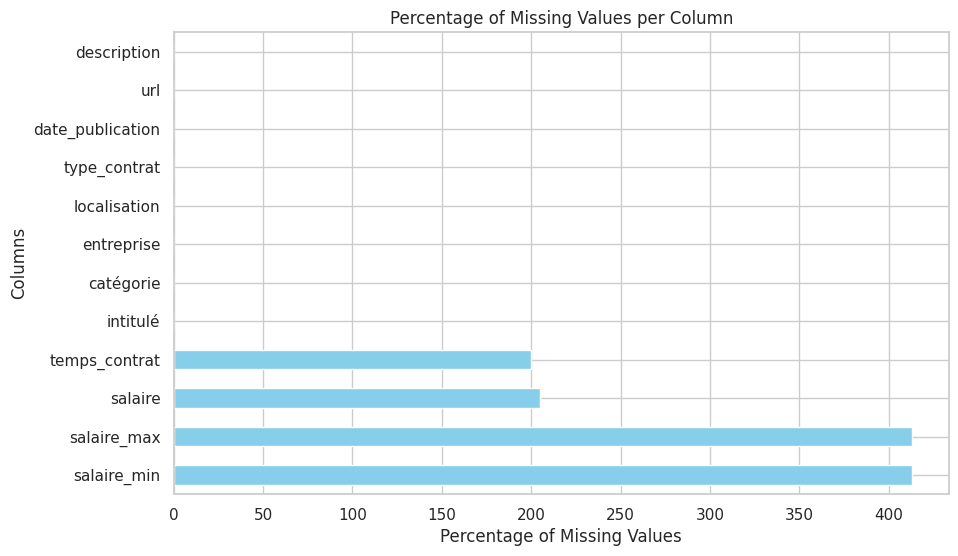


Number of duplicate rows: 0


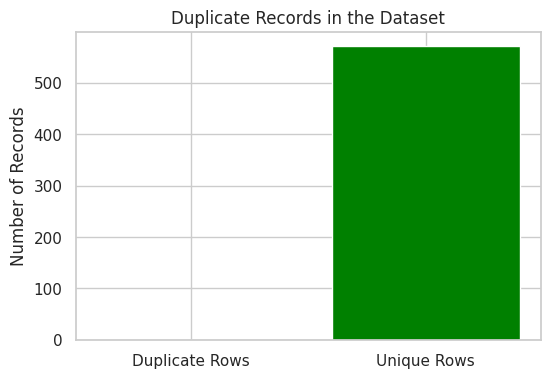


Number of invalid salary ranges: 0

Unique Contract Types: ['CDD' 'CDI' 'Intérim' 'Saisonnier' 'Profession commerciale']

Unique Contract Durations: [nan 'Temps plein' 'Temps partiel' 'Non renseigné']

Number of invalid publication dates: 0

Number of invalid URLs: 0

=== Improving Data Quality ===

Missing values handled.

=== Executing Queries ===
Time taken for Average Salary by Category: 0.0019 seconds
Time taken for Average Salary by Region: 0.0023 seconds
Time taken for Salary Outliers Detection: 0.0023 seconds
Time taken for Contract Type Distribution: 0.0011 seconds
Time taken for Salary Range by Contract Type: 0.0016 seconds
Time taken for Most Common Job Categories: 0.0020 seconds
Time taken for Job Offers by Region and Category: 0.0034 seconds
Time taken for Job Offers per Region Over Time: 0.0051 seconds
Time taken for Monthly Seasonality: 0.0039 seconds
Time taken for Hiring Trends Over Years: 0.0026 seconds
Time taken for Job Title Word Cloud Generation: 0.7337 seconds
T

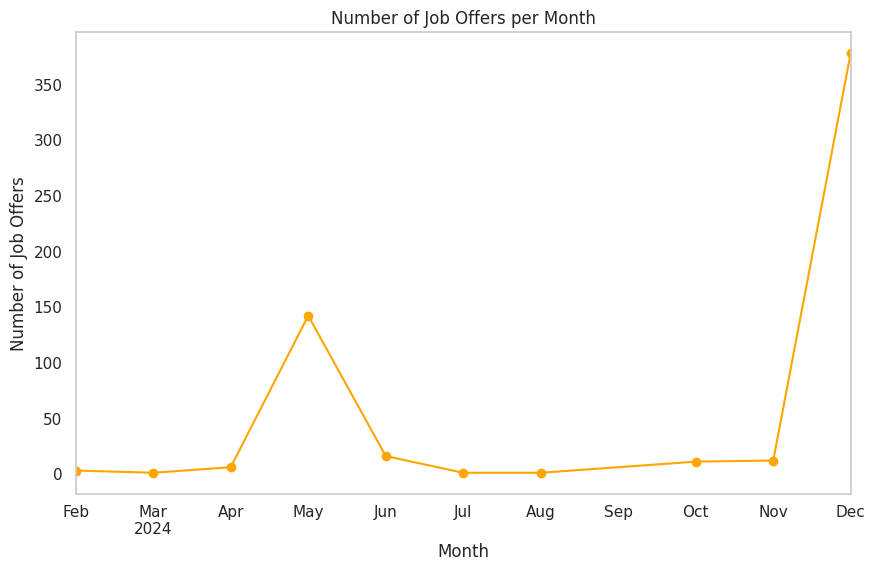

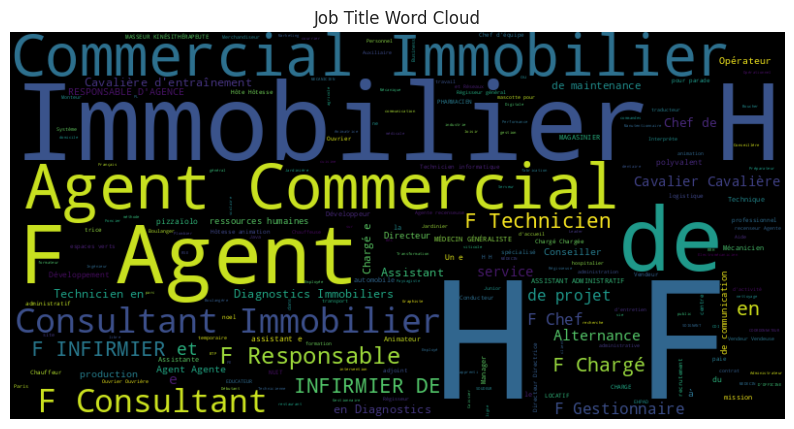

<Figure size 1200x800 with 0 Axes>

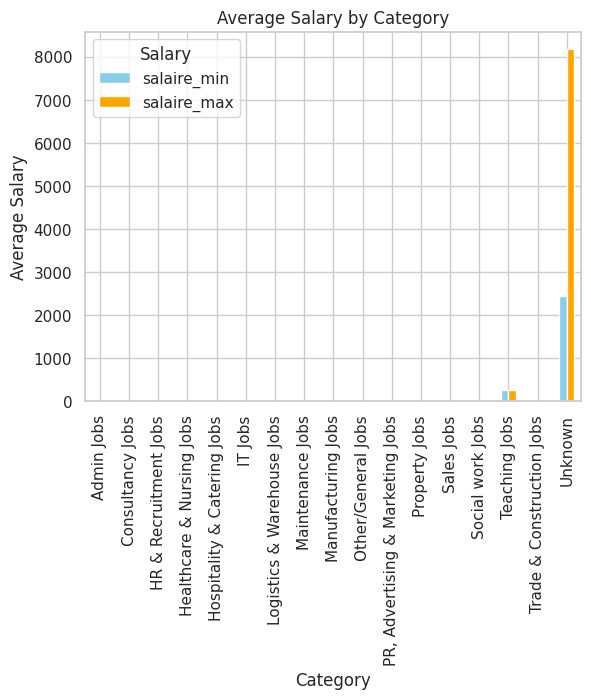

<Figure size 1200x800 with 0 Axes>

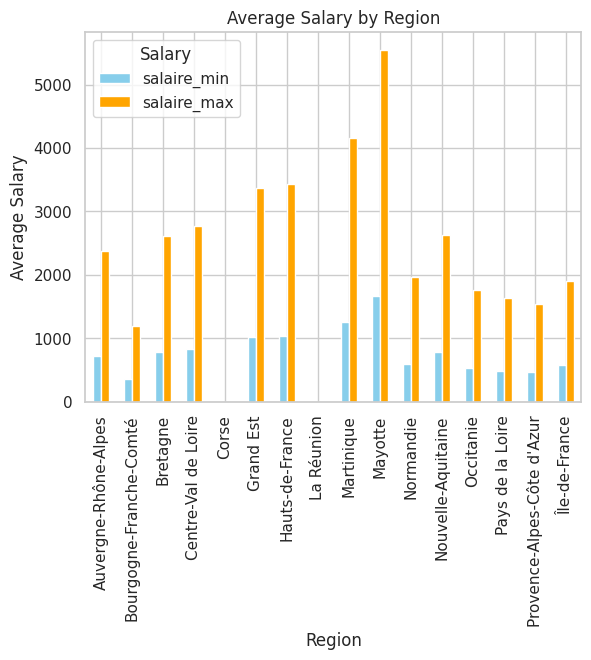

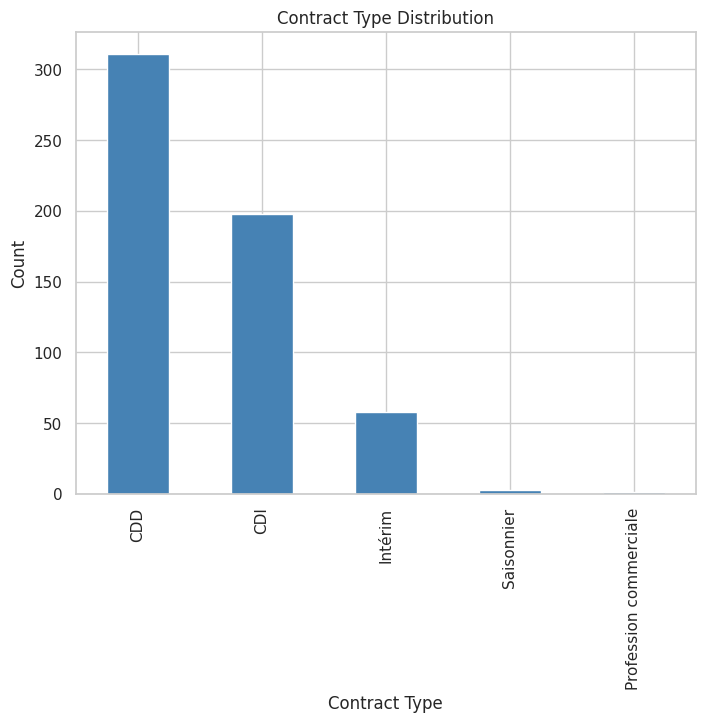

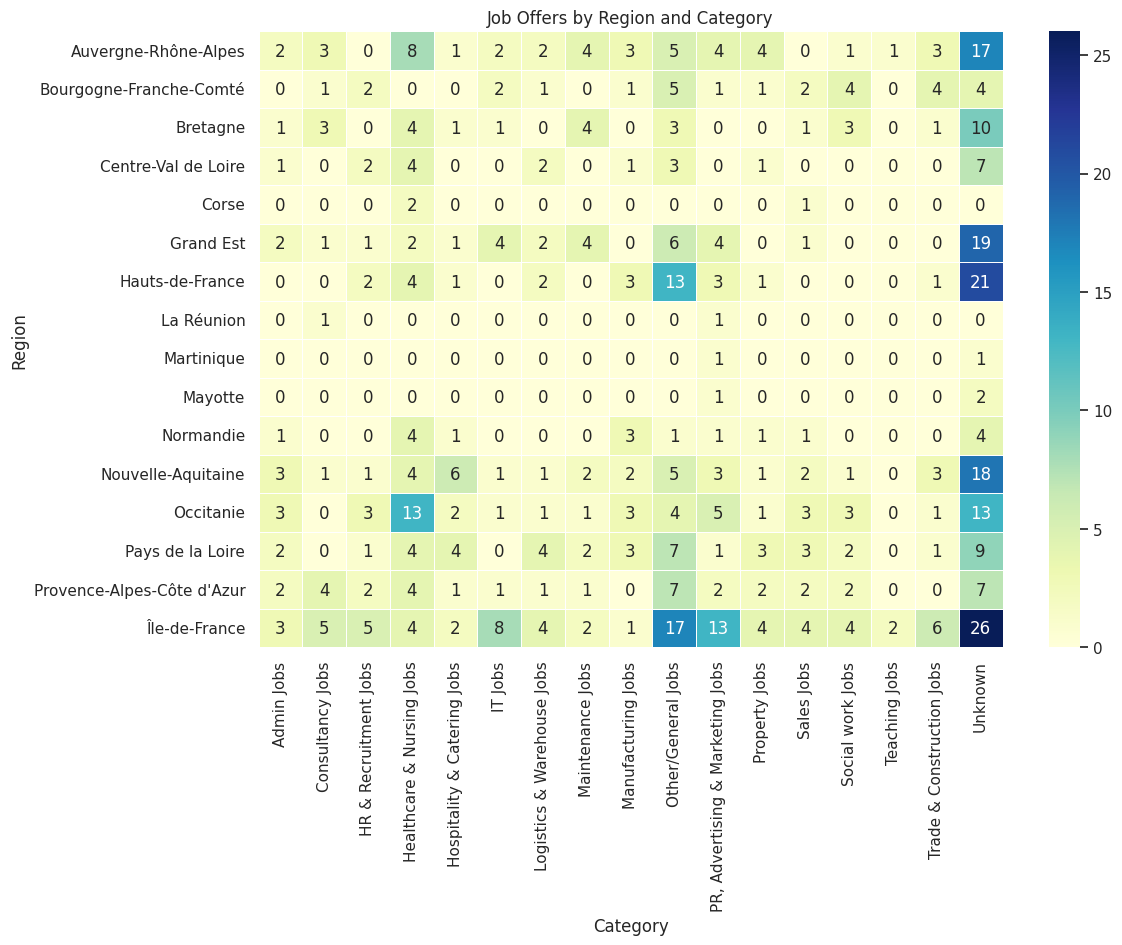

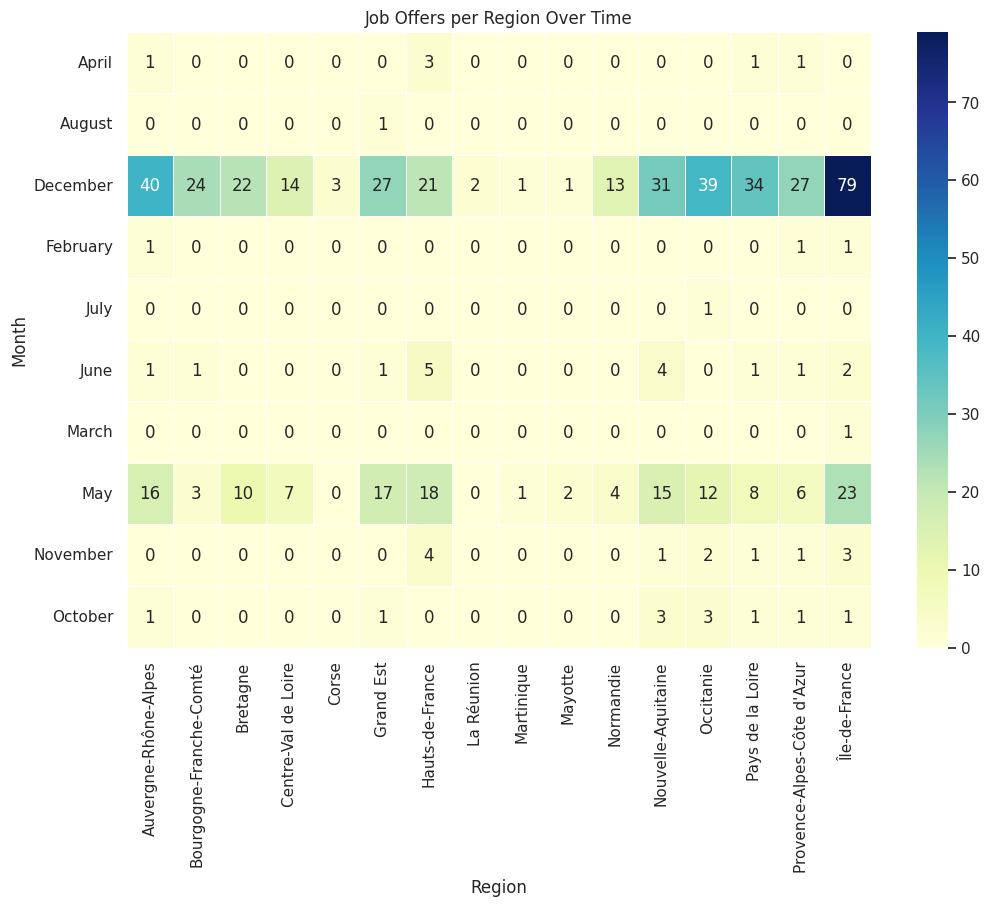

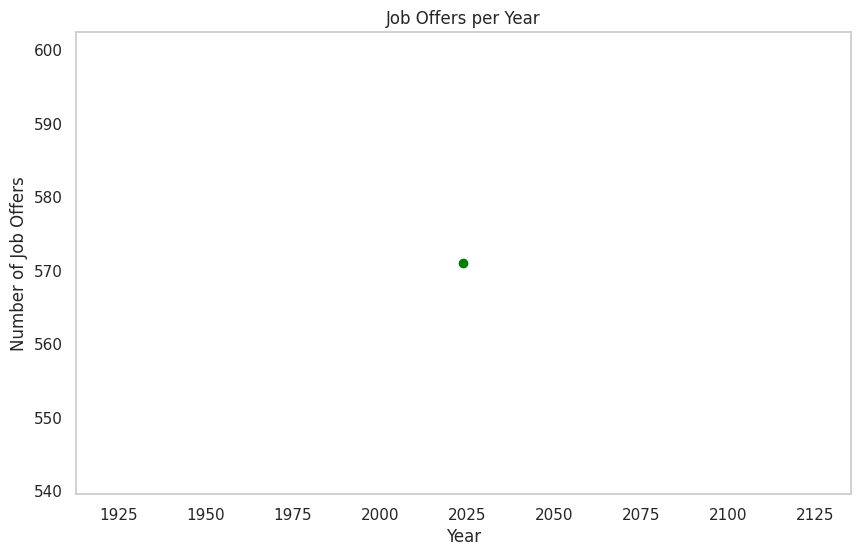

<Figure size 1200x800 with 0 Axes>

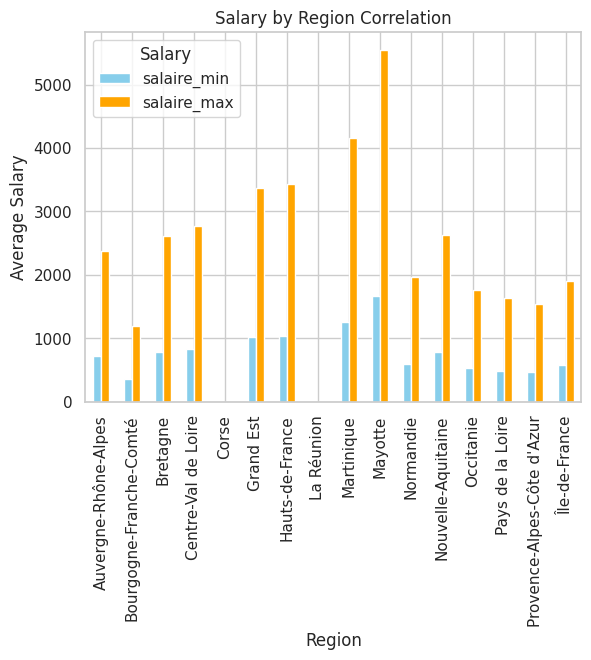

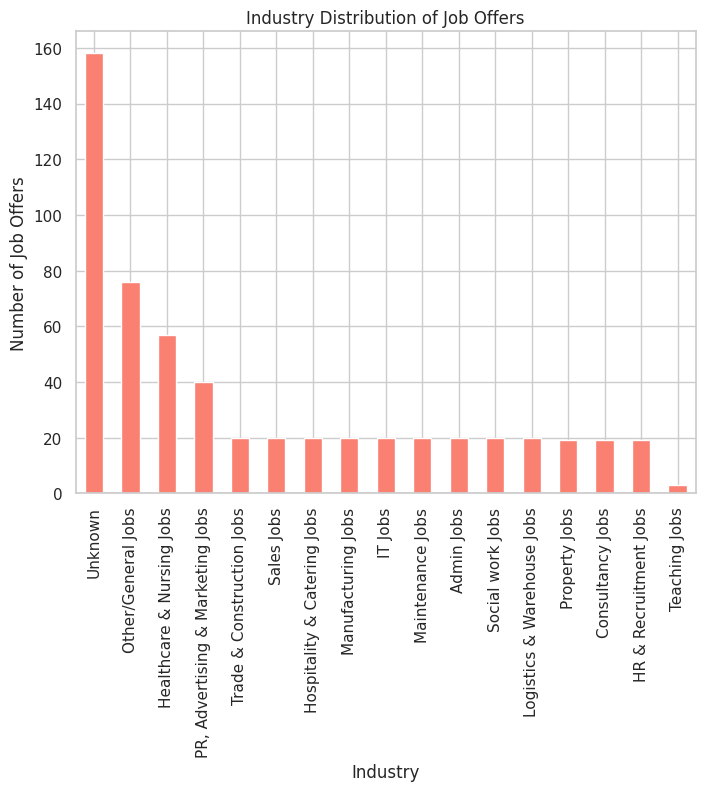

In [58]:
# Main function to orchestrate the steps
def main():
    # Load dataset
    dataset = pd.read_csv('combined_job_listings.csv')
    print('The shape of the dataset', dataset.shape)
    print(dataset.head())

    # Step 1: Check dataset statistics
    print("=== Initial Dataset Statistics ===")
    investigate_data_quality(dataset)

    # Step 2: Improve data quality
    print("\n=== Improving Data Quality ===")
    fix_data_quality(dataset)

    # Step 3: Execute queries
    print("\n=== Executing Queries ===")
    results = analyze_job_offers(dataset)

     # Step 4: Visualize
    print("\n=== Creating Plots ===")
    plot_all_job_offer_results(results)

# Run the main function
if __name__ == "__main__":
    main()